In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


<br>Load libraries

In [3]:
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt

<br>Load data

In [4]:
barcode = pd.read_json("barcode_search_results.json")
synthetic = pd.read_json("synthetic_search_results.json")

<br>

## Transform II.
Loads all InChIKeys, InChIKey hits and detects True-positive (TP) or False-positive (FP) hits (binary column).

In [5]:
def InChIKeys(file_data):
  InChIKey = [[i['InChIKey'],int(j['InChIKey_hits']),
               i['InChIKey']==int(j['InChIKey_hits'])]
              for i in file_data['records']
              for j in i['spectrumCollections'][0]['spectra'][0]['hits']]
  InChIKey = pd.DataFrame({'InChIKey':[row[0] for row in InChIKey],
                         'InChIKey_hits':[row[1] for row in InChIKey],
                         'Positivity':[row[2] for row in InChIKey]})
  return InChIKey

<br>

## Transform IV.
Group TP and FP hits for each record.

In [6]:
def number_TP_FP(InChIKey):
  number = InChIKey.groupby(['InChIKey','Positivity']).count()
  return number

<br>Function for printing InChIKey data

In [7]:
def disp(InChIKey,number):
  print(InChIKey)
  all_InChIKey = len(InChIKey.groupby('InChIKey').count())
  true_positive = len(InChIKey.loc[InChIKey['Positivity'] == True ].groupby(['InChIKey','Positivity']).count())
  false_positive = all_InChIKey - true_positive
  print("\n==========================================================================")
  print(f"Number of all InChIKey: {all_InChIKey}")
  print(f"Number of all true-positive (at least one hit per record was positive): {true_positive}")
  print(f"Number of all true-positive (relative value): {round(true_positive/all_InChIKey*100,2)} %")
  print(f"Number of all false-positive (all hits per record were negative): {false_positive}")
  print(f"Number of all false-positive (relative value): {round(false_positive/all_InChIKey*100,2)} %")
  print("==========================================================================\n")
  print(number)

<br>Barcode data

In [8]:
disp(InChIKeys(barcode),number_TP_FP(InChIKeys(barcode)))

     InChIKey  InChIKey_hits  Positivity
0          33             33        True
1          33             27       False
2          24             24        True
3          44             37       False
4          44             44        True
..        ...            ...         ...
262        81             52       False
263        81             81        True
264        81             75       False
265        34             34        True
266        34             69       False

[267 rows x 3 columns]

Number of all InChIKey: 94
Number of all true-positive (at least one hit per record was positive): 88
Number of all true-positive (relative value): 93.62 %
Number of all false-positive (all hits per record were negative): 6
Number of all false-positive (relative value): 6.38 %

                     InChIKey_hits
InChIKey Positivity               
0        True                    1
1        True                    1
2        True                    1
3        False               

<br>Synthetic data

In [9]:
disp(InChIKeys(synthetic),number_TP_FP(InChIKeys(synthetic)))

     InChIKey  InChIKey_hits  Positivity
0          33             33        True
1          33             27       False
2          33             27       False
3          24             24        True
4          44             44        True
..        ...            ...         ...
295        46             46        True
296        81             75       False
297        81             52       False
298        34             34        True
299        34             34        True

[300 rows x 3 columns]

Number of all InChIKey: 95
Number of all true-positive (at least one hit per record was positive): 85
Number of all true-positive (relative value): 89.47 %
Number of all false-positive (all hits per record were negative): 10
Number of all false-positive (relative value): 10.53 %

                     InChIKey_hits
InChIKey Positivity               
0        True                    2
1        True                    2
2        True                    1
3        False             

<br>

## Transform III.
Loads all Metadata, Metadata hits and calculates their absolute difference.

In [10]:
def Metadatas(file):

  # Load Metadata
  Metadata = [[float(j['metadata']['metadata.analyzer']),
             float(j['metadata']['metadata.polarity']),
             j['metadata']['metadata.scanRangeMax'],
             j['metadata']['metadata.scanRangeMin'],
             j['metadata']['msStageTarget'],
             j['metadata']['nce'],
             float(j['metadata']['ionActivation']),
             float(k['metadata']['metadata.analyzer_hits']),
             float(k['metadata']['metadata.polarity_hits']),
             k['metadata']['metadata.scanRangeMax_hits'],
             k['metadata']['metadata.scanRangeMin_hits'],
             k['metadata']['msStageTarget_hits'],
             k['metadata']['nce_hits'],
             float(k['metadata']['ionActivation_hits'])]
            for i in file['records']
            for j in i['spectrumCollections'][0]['spectra']
            for k in i['spectrumCollections'][0]['spectra'][0]['hits']]

  # Metadata values
  Values = pd.DataFrame({'Analyzer':[row[0] for row in Metadata],
                         'Polarity':[row[1] for row in Metadata],
                         'ScanRangeMax':[row[2] for row in Metadata],
                         'ScanRangeMin':[row[3] for row in Metadata],
                         'MsStageTarget':[row[4] for row in Metadata],
                         'NCE':[row[5] for row in Metadata],
                         'IonActivation':[row[6] for row in Metadata]})
  
  # Metadata hit values
  Hits = pd.DataFrame({'Analyzer':[row[7] for row in Metadata],
                       'Polarity':[row[8] for row in Metadata],
                       'ScanRangeMax':[row[9] for row in Metadata],
                       'ScanRangeMin':[row[10] for row in Metadata],
                       'MsStageTarget':[row[11] for row in Metadata],
                       'NCE':[row[12] for row in Metadata],
                       'IonActivation':[row[13] for row in Metadata]})

  # Absolute differences
  Differences = pd.DataFrame({'Analyzer':[abs(row[0]-row[7]) for row in Metadata],
                            'Polarity':[abs(row[1]-row[8]) for row in Metadata],
                            'ScanRangeMax':[abs(row[2]-row[9]) for row in Metadata],
                            'ScanRangeMin':[abs(row[3]-row[10]) for row in Metadata],
                            'MsStageTarget':[abs(row[4]-row[11]) for row in Metadata],
                            'NCE':[abs(row[5]-row[12]) for row in Metadata],
                            'IonActivation':[abs(row[6]-row[13]) for row in Metadata]})
  return Differences, Values, Hits

<br>

### Barcode Metadata
Absolute difference of Metadata and its hit.

In [11]:
[Differences, Values, Hits] = Metadatas(barcode)
Differences

,Analyzer,Polarity,ScanRangeMax,ScanRangeMin,MsStageTarget,NCE,IonActivation
0,1.0,0.0,0.194655,0.0,0.0,0.052632,1.0
1,1.0,0.0,0.194655,0.0,0.0,0.052632,1.0
2,1.0,0.0,0.194821,0.0,0.0,0.052632,0.0
3,1.0,0.0,0.194512,0.0,0.0,0.026316,1.0
4,1.0,0.0,0.194512,0.0,0.0,0.026316,1.0
...,...,...,...,...,...,...,...
262,1.0,0.0,0.113339,0.0,0.0,0.000000,0.0
263,1.0,0.0,0.113339,0.0,0.0,0.000000,0.0
264,1.0,0.0,0.113339,0.0,0.0,0.000000,0.0
265,1.0,0.0,0.113322,0.0,0.0,0.052632,0.0


<br>

### Synthetic Metadata
Absolute difference of Metadata and its hit.

In [12]:
[Differences, Values, Hits] = Metadatas(synthetic)
Differences

,Analyzer,Polarity,ScanRangeMax,ScanRangeMin,MsStageTarget,NCE,IonActivation
0,1.0,0.0,0.194655,0.0,0.0,0.157895,1.0
1,1.0,0.0,0.194655,0.0,0.0,0.157895,1.0
2,1.0,0.0,0.194655,0.0,0.0,0.026316,1.0
3,1.0,0.0,0.194821,0.0,0.0,0.078947,0.0
4,1.0,0.0,0.194512,0.0,0.0,0.210526,0.0
...,...,...,...,...,...,...,...
295,1.0,0.0,0.113277,0.0,0.0,0.236842,0.0
296,1.0,0.0,0.113339,0.0,0.0,0.184211,0.0
297,1.0,0.0,0.113339,0.0,0.0,0.000000,0.0
298,1.0,0.0,0.113322,0.0,0.0,0.289474,0.0


<br>

## Load I.

Calculates relative ranks (Cosine, Denver, Nist) and specifies them by TP/FP hits.

In [13]:
def relative_ranks(file,f_type):

  # Load file
  import json
  with open(file) as data_file:    
      data = json.load(data_file)  
  data_norm = pd.json_normalize(data,record_path=['records'])

  # Presets
  rrank_cosine, rrank_denver, rrank_nist = [], [], []
  cosine_tp, denver_tp, nist_tp = [], [], []
  cosine_fp, denver_fp, nist_fp = [], [], []

  InChIKey = InChIKeys(f_type)
  count = 0

  for i in range(len(data_norm)):
    
    # Number of hits for each record
    num_of_hits = len(data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'])
    for k in range(num_of_hits):

      # Ranks data
      cosine = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['cosineMatch_rank']
      denver = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['denverMatch_rank']
      nist = data['records'][i]['spectrumCollections'][0]['spectra'][0]['hits'][k]['nistMatch_rank']
      
      # Relative ranks
      if(num_of_hits == 1):
        score_cosine, score_denver, score_nist = 0, 0, 0
      else:
        score_cosine = (cosine - 1) / (num_of_hits - 1)
        score_denver = (denver - 1) / (num_of_hits - 1)
        score_nist = (nist- 1) / (num_of_hits - 1)

      rrank_cosine.append(score_cosine)
      rrank_denver.append(score_denver)
      rrank_nist.append(score_nist)

      # Relative ranks vs. TP/FP hits
      if InChIKey['Positivity'][count] == True:
        cosine_tp.append(score_cosine)
        denver_tp.append(score_denver)
        nist_tp.append(score_nist)
      else:
        cosine_fp.append(score_cosine)
        denver_fp.append(score_denver)
        nist_fp.append(score_nist)
      count += 1

  # Output data
  rrank = pd.DataFrame({'Cosine': rrank_cosine,
                        'Denver': rrank_denver,
                        'Nist': rrank_nist})
  rank_tp = pd.DataFrame({'Cosine': cosine_tp,
                        'Denver': denver_tp,
                        'Nist': nist_tp})
  rank_fp = pd.DataFrame({'Cosine': cosine_fp,
                        'Denver': denver_fp,
                        'Nist': nist_fp})
  return rrank, rank_tp, rank_fp

<br>Plots of TP/FP hits of relative ranks (FP hits lie over TP hits) for Barcode library.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


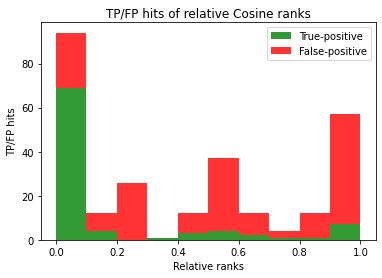

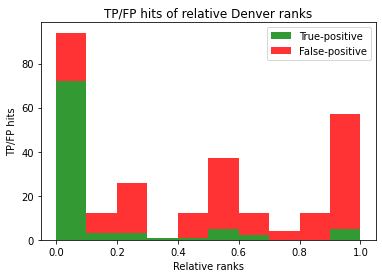

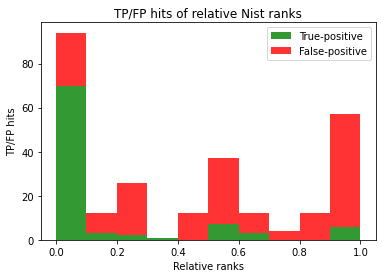

In [14]:
# Loads ranks
[rrank, rank_tp, rank_fp] = relative_ranks('barcode_search_results.json',barcode)

# Presets
metrics = ['Cosine','Denver','Nist']

# Plots histograms
for metric in range(len(metrics)):
  plt.figure(metric)
  plt.hist([rank_tp[metrics[metric]],rank_fp[metrics[metric]]], color=['green','red'],
           stacked=True, alpha=0.8, label=['True-positive','False-positive'])
  plt.title(f"TP/FP hits of relative {metrics[metric]} ranks")
  plt.xlabel("Relative ranks")
  plt.ylabel("TP/FP hits")
  plt.legend(loc='upper right')
plt.show()

<br>Plots of TP/FP hits of relative ranks (FP hits lie over TP hits) for Synthetic library.

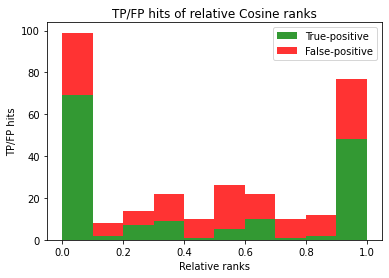

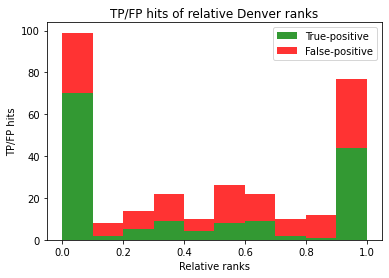

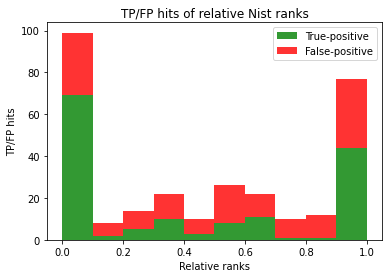

In [15]:
# Loads ranks
[rrank, rank_tp, rank_fp] = relative_ranks('synthetic_search_results.json',synthetic)

# Presets
metrics = ['Cosine','Denver','Nist']

# Plots histograms
for metric in range(len(metrics)):
  plt.figure(metric)
  plt.hist([rank_tp[metrics[metric]],rank_fp[metrics[metric]]], color=['green','red'],
           stacked=True, alpha=0.8, label=['True-positive','False-positive'])
  plt.title(f"TP/FP hits of relative {metrics[metric]} ranks")
  plt.xlabel("Relative ranks")
  plt.ylabel("TP/FP hits")
  plt.legend(loc='upper right')
plt.show()

<br>

## Load II.

Correlation between the difference of Metadata and its hit against TP/FP InChIKey.

In [16]:
def crrl(Differences,num):
  # Processed data/methods
  meta_titles = ['Analyzer','Polarity','ScanRangeMax','ScanRangeMin',
                'MsStageTarget','NCE','IonActivation']
  methods = ['pearson','spearman']
  num = 1.0*num['Positivity']

  # Calculation of correlation
  crrC = {}
  for j in meta_titles:
    df = pd.DataFrame({'Data': Differences[j],
                    'Positivity': num})
    crrl = []
    for i in range(2):
      crrl.append(round(df.corr(method=methods[i]).iloc[0,1],4))
    crrC[j] = crrl
  crrC = pd.DataFrame.from_dict(crrC,orient='index',columns=[method.capitalize()
  for method in methods])
  return crrC

<br>Barcode correlation

In [17]:
[Differences, Values, Hits] = Metadatas(barcode)
crrl(Differences,InChIKeys(barcode))

,Pearson,Spearman
Analyzer,NaN,NaN
Polarity,NaN,NaN
ScanRangeMax,0.2063,0.1743
ScanRangeMin,0.1197,0.1198
MsStageTarget,NaN,NaN
NCE,0.2161,0.2710
IonActivation,0.1451,0.1451


The value **NaN** means the zero value of the standard deviation $\sigma$ in correlation $\mu$ (correlation is inversely related to standard deviation.).

<br>Barcode boxplot ($\mu$ is mean value, $\sigma$ is standard deviation)

*   blue colour - Metadata
*   red colour - Metadata hits
*   green dot - mean value

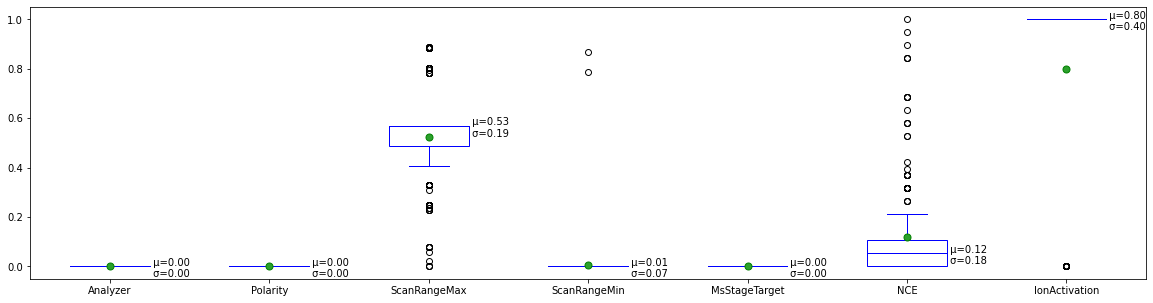

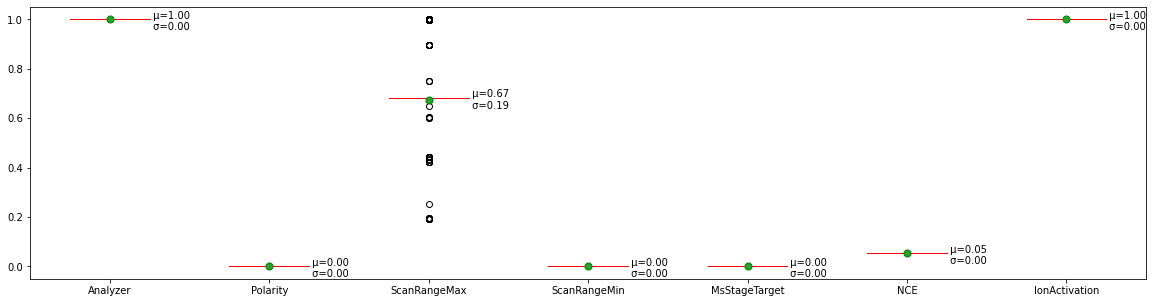

In [18]:
def box_plot(data, edge_color, fill_color, meta_titles):
    bp = plt.boxplot(data, patch_artist=True, labels=meta_titles,
                     showmeans=True, meanprops={"marker": "o",
                       "markeredgecolor": "green",
                       "markersize": "7"})
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

[Differences, Values, Hits] = Metadatas(barcode)
meta_titles = ['Analyzer','Polarity','ScanRangeMax','ScanRangeMin',
                'MsStageTarget','NCE','IonActivation']
data = []
for title in meta_titles:
  data.append(Values[title])
plt.figure(figsize=(20,5))
bp = box_plot(data, 'blue', 'white', meta_titles)
m1 = np.array(data).mean(axis=1)
st1 = np.array(data).std(axis=1)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    plt.annotate(text, xy=(x, y), verticalalignment='center_baseline')
data2 = []
for title in meta_titles:
  data2.append(Hits[title])
plt.figure(figsize=(20,5))
bp2 = box_plot(data2, 'red', 'white', meta_titles)
m2 = np.array(data2).mean(axis=1)
st2 = np.array(data2).std(axis=1)
for i, line in enumerate(bp2['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    plt.annotate(text, xy=(x, y), verticalalignment='center_baseline')
plt.show()

<br>Synthetic correlation

In [19]:
[Differences, Values, Hits] = Metadatas(synthetic)
crrl(Differences,InChIKeys(synthetic))

,Pearson,Spearman
Analyzer,NaN,NaN
Polarity,NaN,NaN
ScanRangeMax,0.1276,0.1248
ScanRangeMin,NaN,NaN
MsStageTarget,NaN,NaN
NCE,0.0904,0.0811
IonActivation,-0.0707,-0.0707


The value **NaN** means the zero value of the standard deviation $\sigma$ in correlation $\mu$ (correlation is inversely related to standard deviation.).

<br>Synthetic boxplot ($\mu$ is mean value, $\sigma$ is standard deviation)

*   blue colour - Metadata
*   red colour - Metadata hits
*   green dot - mean value

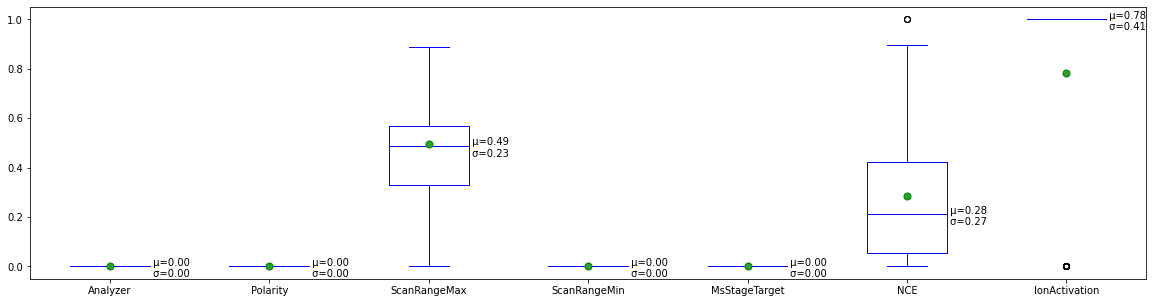

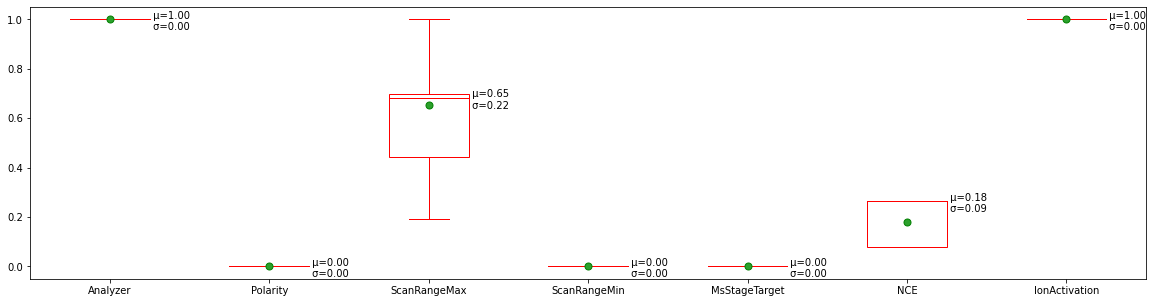

In [20]:
def box_plot(data, edge_color, fill_color, meta_titles):
    bp = plt.boxplot(data, patch_artist=True, labels=meta_titles,
                     showmeans=True, meanprops={"marker": "o",
                       "markeredgecolor": "green",
                       "markersize": "7"})
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

[Differences, Values, Hits] = Metadatas(synthetic)
meta_titles = ['Analyzer','Polarity','ScanRangeMax','ScanRangeMin',
                'MsStageTarget','NCE','IonActivation']
data = []
for title in meta_titles:
  data.append(Values[title])
plt.figure(figsize=(20,5))
bp = box_plot(data, 'blue', 'white', meta_titles)
m1 = np.array(data).mean(axis=1)
st1 = np.array(data).std(axis=1)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m1[i], st1[i])
    plt.annotate(text, xy=(x, y), verticalalignment='center_baseline')
data2 = []
for title in meta_titles:
  data2.append(Hits[title])
plt.figure(figsize=(20,5))
bp2 = box_plot(data2, 'red', 'white', meta_titles)
m2 = np.array(data2).mean(axis=1)
st2 = np.array(data2).std(axis=1)
for i, line in enumerate(bp2['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(m2[i], st2[i])
    plt.annotate(text, xy=(x, y), verticalalignment='center_baseline')
plt.show()

<br>

## Load VI.

Relative number of records with a True-Positive hit for the i-th hit of the record (e. g. the second number from the list represents the proportion of all second hits that are True-positive relative to all hits).

In [21]:
def ranks(InChIKey,file):

  # Number of hits per record
  ranks = [len(j['hits']) for i in file['records'] for j
           in i['spectrumCollections'][0]['spectra']]
  
  # List of zeros (length of max. number of hits in one record)
  diff_ranks = np.zeros(np.max(np.unique(np.array(ranks))))

  # Presets
  actual = InChIKey['InChIKey'][0]-1
  counter = []
  count = 0

  # Number of i-th TP hits (across all records)
  for i in range(len(InChIKey)):
    if InChIKey['InChIKey'][i] == actual:
      count += 1
      if InChIKey['Positivity'][i] == True:
        diff_ranks[count] += 1
        counter.append(count+1)
    else:
      actual = InChIKey['InChIKey'][i]
      count = 0
      if InChIKey['Positivity'][i] == True:
        diff_ranks[count] += 1
        counter.append(count+1)

  # Display data
  data = pd.DataFrame({'Rank': np.unique(ranks).tolist(),
                       'Success rate in %': [round((diff_ranks/sum(diff_ranks)*100)[pos-1],2)
                       for pos in np.unique(ranks)]})
  data.set_index('Rank', inplace=True, drop=True)

  # Plot data
  plt.bar(np.unique(ranks).tolist(), [round((diff_ranks/sum(diff_ranks))[pos-1],2)
                       for pos in np.unique(ranks)], zorder=3)
  plt.title('Hit success per rank')
  plt.xlabel("Rank")
  plt.ylabel("Hit success")
  plt.xticks(np.arange(0, max(ranks)+1, 1.0))
  plt.ylim([0, 1])
  plt.grid(zorder=0)  
  plt.savefig("success_rate.png", dpi=600)
  plt.show()

  return data

<br>Barcode rank success rate

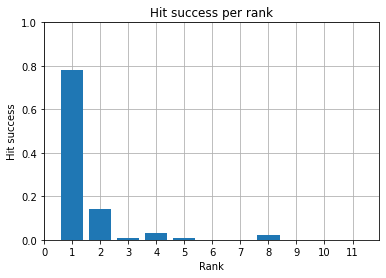

,Success rate in %
Rank,
1,78.26
2,14.13
3,1.09
4,3.26
5,1.09
8,2.17
11,0.00


In [22]:
ranks(InChIKeys(barcode),barcode)

<br> Synthetic rank success rate

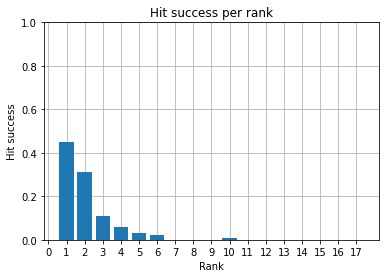

,Success rate in %
Rank,
1,45.45
2,31.17
3,11.04
4,6.49
5,2.60
6,1.95
7,0.00
8,0.00
10,0.65


In [23]:
ranks(InChIKeys(synthetic),synthetic)

<br>Counts and plots number of TP and FP hits for each record - e.g. counts how many records does have one (two, three, ...) TP/FP hits.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


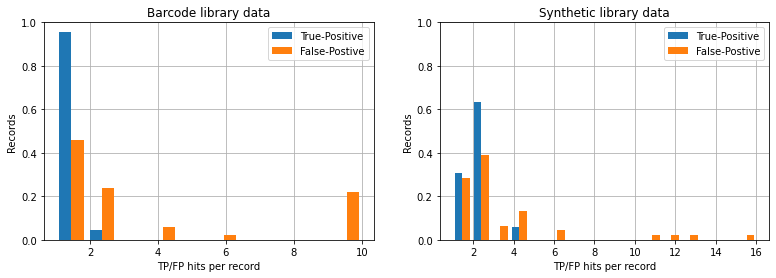

In [24]:
# Preloads
libraries = [barcode,synthetic]
libraries2 = ['Barcode','Synthetic']
plt.figure(figsize=(13,4))

# Calculate number of TP/FP hits per record and plot
for i in range(2):
  InChIKey = InChIKeys(libraries[i])
  TP_hits = (InChIKey[InChIKey['Positivity'] == True].groupby(
      ['InChIKey','Positivity']).count())['InChIKey_hits'].tolist()
  FP_hits = (InChIKey[InChIKey['Positivity'] == False].groupby(
      ['InChIKey','Positivity']).count())['InChIKey_hits'].tolist()
  if max(TP_hits) > max(FP_hits):
    bin = max(TP_hits)
  else:
    bin = max(FP_hits)
  plt.subplot(1,2,i+1)
  plt.hist([TP_hits,FP_hits], bins=bin,
           label=['True-Positive', 'False-Postive'],
           weights=[np.ones_like(TP_hits)/len(TP_hits),
                    np.ones_like(FP_hits)/len(FP_hits)], zorder=3)
  plt.title(libraries2[i]+' library data')
  plt.xlabel("TP/FP hits per record")
  plt.ylabel("Records")
  plt.legend(loc='upper right')
  plt.ylim([0, 1])
  plt.grid(zorder=0)
plt.show()